In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler, 
    PolynomialFeatures,
    KBinsDiscretizer
)
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [3]:
fina_ran = pd.read_csv('data/Train.csv')
fina_ran.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [4]:
finan_ran = fina_ran.drop(['country','year','uniqueid','relationship_with_head'], axis=1)

In [5]:
finan_ran.value_counts('bank_account')

bank_account
No     20212
Yes     3312
Name: count, dtype: int64

<Axes: xlabel='bank_account', ylabel='count'>

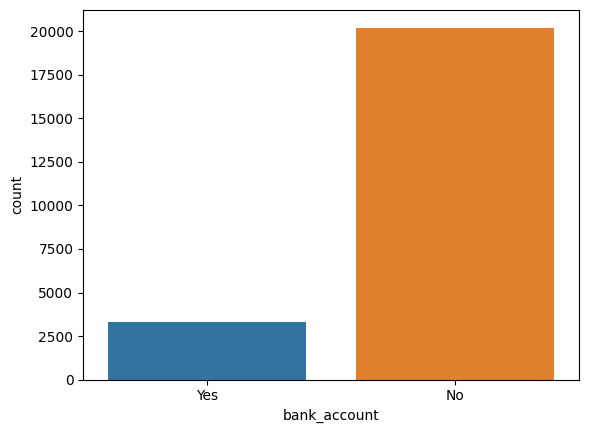

In [6]:
sns.countplot(x='bank_account', data=finan_ran)

In [7]:
le = LabelEncoder()
finan_ran['bank_account'] = le.fit_transform(finan_ran['bank_account'])

X = finan_ran.drop('bank_account', axis=1)
y = finan_ran['bank_account']

In [8]:
X_train, X_test,y_train, y_test = train_test_split(X,y , test_size= 0.20, random_state=42, stratify=y)

In [9]:
num_features = list(X_train.select_dtypes(exclude=['object']).columns)
cat_features = list(X_train.select_dtypes(include=['object']).columns)

num_transformer = ImbPipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaling', StandardScaler()),
        ('poly', PolynomialFeatures(degree=3))
    ])
cat_transformer = ImbPipeline(steps=
                           [
        ('imputer', SimpleImputer(strategy='most_frequent')),
    
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num_transformer', num_transformer, num_features),
        ('cat_transformer', cat_transformer, cat_features)
        
    ],remainder='passthrough')

In [10]:
baseline_ran_ = ImbPipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('Smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs = -1, verbose = 1))
         
         ])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s


Test-------------------
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      4043
           1       0.48      0.44      0.46       662

    accuracy                           0.85      4705
   macro avg       0.69      0.68      0.69      4705
weighted avg       0.85      0.85      0.85      4705

Accuracy score: 0.8541976620616366


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Text(0.5, 1.0, 'Confusion Matrix')

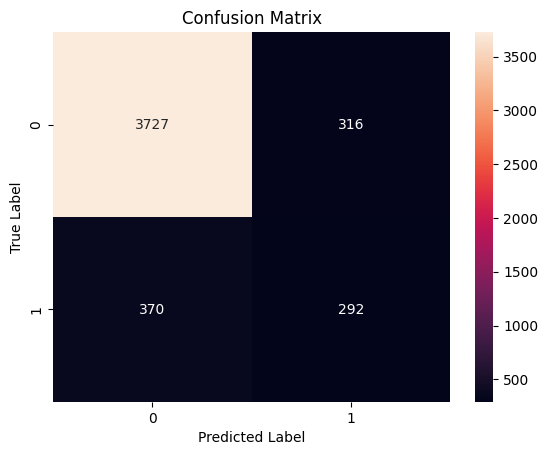

In [11]:
baseline_ran_.fit(X_train, y_train)

y_ran= baseline_ran_.predict(X_test)



print('Test-------------------')
print(classification_report(y_test, y_ran))
print('Accuracy score:', accuracy_score(y_test, y_ran))

cm=confusion_matrix(y_test, y_ran)
sns.heatmap(cm, annot=True, fmt ='g')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

In [12]:
param_grid = {
    'classifier__n_estimators': np.linspace(10, 200).astype(int),
    'classifier__max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'classifier__max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'classifier__max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__bootstrap': [True, False]
}


from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(baseline_ran_, param_grid, n_jobs=-1, 
                        scoring='recall', cv=3, 
                        n_iter=10, verbose=5, random_state=42)

rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    1.6s finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num_transformer',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaling',
                                                                                                StandardScaler()),
                                                                                               ('poly',
                                                                                                PolynomialFeatures(degree=3))]),
                                                                               ['household_size',
                                                                                'age_of_respondent']),
                                                                              ('cat_transformer',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImpu...
                                                                       11, 11,
                                                                       11, 11,
                                                                       11, 11,
                                                                       11, 11,
                                                                       11, 11,
                                                                       11, 11,
                                                                       12, 12,
                                                                       12, 12, ...],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': array([ 10,  13,  17,  21,  25,  29,  33,  37,  41,  44,  48,  52,  56,
        60,  64,  68,  72,  75,  79,  83,  87,  91,  95,  99, 103, 106,
       110, 114, 118, 122, 126, 130, 134, 137, 141, 145, 149, 153, 157,
       161, 165, 168, 172, 176, 180, 184, 188, 192, 196, 200])},
                   random_state=42, scoring='recall', verbose=5)

In [13]:
rs.best_params_

{'classifier__n_estimators': 91,
 'classifier__min_samples_split': 10,
 'classifier__max_leaf_nodes': 19,
 'classifier__max_features': 0.6,
 'classifier__max_depth': 5,
 'classifier__bootstrap': False}

In [14]:
best_model = rs.best_estimator_

In [15]:
best_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    1.4s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaling',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3))]),
                                                  ['household_size',
                                                   'age_of_respondent']),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('o...
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['location_type',
                                                   'cellphone_access',
                                                   'gender_of_respondent',
                                                   'marital_status',
                                                   'education_level',
                                                   'job_type'])])),
                ('Smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=0.6, max_leaf_nodes=19,
                                        min_samples_split=10, n_estimators=91,
                                        n_jobs=-1, random_state=42,
                                        verbose=1))])

In [16]:
rf_predictions = best_model.predict(X_test)


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  91 out of  91 | elapsed:    0.0s finished


In [26]:
best_model = rs.best_estimator_

In [27]:
rf_predictions = best_model.predict(X_test)


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 157 out of 157 | elapsed:    0.0s finished


In [17]:
print(classification_report(y_test, rf_predictions))
print(accuracy_score(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.94      0.75      0.84      4043
           1       0.32      0.72      0.44       662

    accuracy                           0.75      4705
   macro avg       0.63      0.74      0.64      4705
weighted avg       0.86      0.75      0.78      4705

0.7466524973432519


In [18]:
rf_train = best_model.predict(X_train)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  91 out of  91 | elapsed:    0.0s finished


In [19]:
print(classification_report(y_train, rf_train))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84     16169
           1       0.32      0.71      0.44      2650

    accuracy                           0.75     18819
   macro avg       0.63      0.73      0.64     18819
weighted avg       0.85      0.75      0.78     18819

